In [100]:

import gzip
from collections import defaultdict
import math
import operator
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
from sklearn import linear_model
import warnings
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import scipy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
class Utilites:
    def readGz(path):
        for l in gzip.open(path, 'rt',encoding='utf-8'):
            yield eval(l)

    def punctuations():
        return set(string.punctuation)

    def readCSV(path):
        f = gzip.open(path, 'rt')
        f.readline()
        for l in f:
            u, b, r = l.strip().split(',')
            r = int(r)
            yield u, b, r

    def Cosine(x1, x2):
        numer = 0
        norm1 = 0
        norm2 = 0
        for a1, a2 in zip(x1, x2):
            numer += a1*a2
            norm1 += a1**2
            norm2 += a2**2
        if norm1*norm2:
            return numer / math.sqrt(norm1*norm2)
        return 0

    def calcAcc(y, predY):
        assert( len(y) == len(predY))
        correct = np.array(y) == np.array(predY)
        return sum(correct) / len(correct)
    



In [2]:
users_review_data = []
reviews_data = []
users_items_data = []
items_data = []
bundle_data = []

for d in Utilites.readGz("user_reviews.json.gz"):
    users_review_data.append(d)

#for d in Utilites.readGz("/work/steam_reviews.json.gz"):
    #reviews_data.append(d)

for d in Utilites.readGz("users_items.json.gz"):
    users_items_data.append(d)

for d in Utilites.readGz("steam_games.json.gz"):
    items_data.append(d)

for d in Utilites.readGz("bundle_data.json.gz"):
    bundle_data.append(d)

In [3]:
users_items_train = []
users_items_validation = []
users_items_test = []
users_per_item_train = defaultdict(set)
items_per_user_train = defaultdict(set)
times_per_game_total = defaultdict()
times_per_game = defaultdict(list)


for d in users_items_data:
    games_played_by_user = d['items']
    random.shuffle(games_played_by_user)

    for i in range(len(games_played_by_user)):
        times_per_game[games_played_by_user[i]['item_id']].append(
            games_played_by_user[i]['playtime_forever'])
        if(games_played_by_user[i]['item_id'] in times_per_game_total):
            if(games_played_by_user[i]['playtime_forever'] != 0):
                times_per_game_total[games_played_by_user[i]['item_id']][0] += games_played_by_user[i]['playtime_forever']
                times_per_game_total[games_played_by_user[i]['item_id']][1] += 1
        else:
            times_per_game_total[games_played_by_user[i]['item_id']] = [games_played_by_user[i]['playtime_forever'],1]
        if(i < len(games_played_by_user) * 0.6):
            users_items_train.append((d['user_id'], games_played_by_user[i]))
            items_per_user_train[d['user_id']].add((games_played_by_user[i]['item_id'],games_played_by_user[i]['playtime_forever'],games_played_by_user[i]['playtime_2weeks']))
            users_per_item_train[games_played_by_user[i]['item_id']].add((d['user_id'],games_played_by_user[i]['playtime_forever'],games_played_by_user[i]['playtime_2weeks']))

        elif(i < len(games_played_by_user) * 0.8):
            users_items_validation.append((d['user_id'], games_played_by_user[i]))
        else:
            users_items_test.append((d['user_id'], games_played_by_user[i]))

games = defaultdict()
for d in items_data:
    if(d.__contains__('id')):
        games[d['id']] = d
    else:
        if(d['url'].split('/')[-1] != ''):
            games[d['url'].split('/')[-1]] = d


{'url': 'http://store.steampowered.com/', 'price': 19.99, 'discount_price': 14.99, 'early_access': False}
{'publisher': 'Warner Bros. Interactive Entertainment, Feral Interactive (Mac)', 'genres': ['Action', 'Adventure'], 'app_name': 'Batman: Arkham City - Game of the Year Edition', 'sentiment': 'Overwhelmingly Positive', 'title': 'Batman: Arkham City - Game of the Year Edition', 'url': 'http://store.steampowered.com/app/200260', 'release_date': '2012-09-07', 'tags': ['Action', 'Open World', 'Batman', 'Adventure', 'Stealth', 'Third Person', 'Superhero', 'Singleplayer', "Beat 'em up", 'Comic Book', 'Detective', 'Fighting', 'Atmospheric', 'Story Rich', 'Action-Adventure', 'Cinematic', 'Controller', '3D Vision', 'Metroidvania', 'Sandbox'], 'metascore': 91, 'price': 19.99, 'early_access': False, 'specs': ['Single-player', 'Steam Achievements', 'Steam Trading Cards', 'Partial Controller Support', 'Steam Cloud'], 'developer': 'Rocksteady Studios,Feral Interactive (Mac)'}


In [4]:
def prep_data(data):
    x =[]
    y = []
    for user,gameInfo in data:
        if(gameInfo['playtime_forever'] == 0): y.append(0)
        elif(gameInfo['playtime_forever'] <= 45): y.append(1)
        elif(gameInfo['playtime_forever'] <= 220): y.append(2)
        elif(gameInfo['playtime_forever'] <= 840): y.append(3)
        else: y.append(4)
        x.append((user,gameInfo['item_id']))
    return x, y

In [5]:
trainX, trainY = prep_data(users_items_train)
valX, valY = prep_data(users_items_validation)
testX, testY = prep_data(users_items_test)

#### Visualize the distribution of data (time played by player)

Text(0, 0.5, 'Number of players')

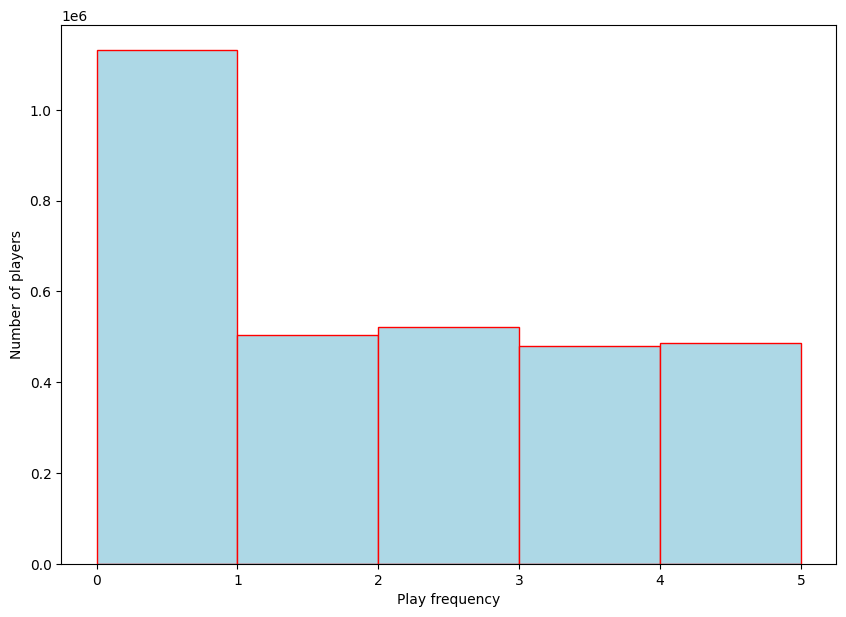

In [108]:

a = np.array(trainY)
plot, ax= plt.subplots(figsize =(10, 7))
threshold = []
for i in range(0,6,1):
    threshold.append(i)
plt.hist(a, bins=threshold,color = "lightblue", ec="red")
ax.set_xlabel("Play frequency")
ax.set_ylabel("Number of players")


In [205]:
timesPerGameMean = {}
timesPerGameMedian = {}
timesPerCategory = {}
for game in times_per_game:
    timesPerGameMean[game] = np.mean(times_per_game[game])
    timesPerGameMedian[game] = np.median(times_per_game[game])
    for g in games:
        if('genres' in games[g]):
            genres = games[g]['genres']
        gameName = games[g]['app_name']
        for gameCategory in genres:
            print(f'Game {gameName} {genres} ')



Game Lost Summoner Kitty ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy'] 
Game Lost Summoner Kitty ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy'] 
Game Lost Summoner Kitty ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy'] 
Game Lost Summoner Kitty ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy'] 
Game Lost Summoner Kitty ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy'] 
Game Ironbound ['Free to Play', 'Indie', 'RPG', 'Strategy'] 
Game Ironbound ['Free to Play', 'Indie', 'RPG', 'Strategy'] 
Game Ironbound ['Free to Play', 'Indie', 'RPG', 'Strategy'] 
Game Ironbound ['Free to Play', 'Indie', 'RPG', 'Strategy'] 
Game Real Pool 3D - Poolians ['Casual', 'Free to Play', 'Indie', 'Simulation', 'Sports'] 
Game Real Pool 3D - Poolians ['Casual', 'Free to Play', 'Indie', 'Simulation', 'Sports'] 
Game Real Pool 3D - Poolians ['Casual', 'Free to Play', 'Indie', 'Simulation', 'Sports'] 
Game Real Pool 3D - Poolians ['Casual', 'Free to Play', 'Indie', 'Simulation

KeyError: 'genres'

In [184]:
def evalModel(model, dataX, dataY, args=[]):
    predY = model(dataX,args)
    acc = Utilites.calcAcc(predY, dataY)
    return acc

##### Trivial Predictor (always predict that a user never plays the game)

In [198]:
# Always predict that a user will never play a game
def modelPredTrivial(data, args={}):
    y_pred = [0] * len(data)
    return y_pred

##### Predict based on popularity of game (distance to mean time played)

In [199]:
def modelPredPopularityDifference(data,args={'mode':"mean"}):
    y_pred = []
    threshold = np.array([0, 45,220,840, 1460])
    for user, item in data:
        if(args['mode'] == "mean"):
            avg_time = timesPerGameMean[item]
        else:
            avg_time = timesPerGameMedian[item]
        diff = np.abs(threshold - avg_time)
        y_pred.append(np.argmin(diff))
    return y_pred

##### Predict based on popularity of game (based on paritcular threashold from mean time played)


In [200]:
def modelPredPopularityThreashold(data, args={'mode':"mean"}):
    y_pred = []
    for user, item in data:
        if(args['mode'] == "mean"):
            avg_time = timesPerGameMean[item]
        else:
            avg_time = timesPerGameMedian[item]
        if(avg_time < 20): 
            y_pred.append(0)
        elif(0 < avg_time <= 45): y_pred.append(1)
        elif(avg_time <= 220): y_pred.append(2)
        elif(avg_time<= 840): y_pred.append(3)
        else: y_pred.append(4)
    return y_pred

### Baseline prediction

In [201]:
args = {"mode":"mean"}
# Predict based on popularity
print(f'Popularity predictor(difference) acc: {evalModel(modelPredPopularityDifference,testX,testY,args)}')

# Predict based on popularity
print(f'Popularity predictor(threashold) acc: {evalModel(modelPredPopularityThreashold,testX,testY,args)}')

# Predict that a player that bought the game will never play it
print(f'Trivial predictor acc: {evalModel(modelPredTrivial,testX,testY,args)}')

Popularity predictor(difference) acc: 0.34064861790808004
Popularity predictor(threashold) acc: 0.332386496854687
Trivial predictor acc: 0.3638925056246477


In [202]:
args = {"mode":"median"}
# Predict based on popularity
print(f'Popularity predictor(difference) acc: {evalModel(modelPredPopularityDifference,testX,testY,args)}')

# Predict based on popularity
print(f'Popularity predictor(threashold) acc: {evalModel(modelPredPopularityThreashold,testX,testY,args)}')

# Predict that a player that bought the game will never play it
print(f'Trivial predictor acc: {evalModel(modelPredTrivial,testX,testY,args)}')


Popularity predictor(difference) acc: 0.4154257521563228
Popularity predictor(threashold) acc: 0.443338970452516
Trivial predictor acc: 0.3638925056246477
